# Analyse des pays pour une expansion à l'internationale

## La poule qui chante

In [133]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, decomposition, metrics
from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

### Importation des données, filtrage des colonnes

Importation des données fournies (disponibilité alimentaire, population) :

In [134]:
data = pd.read_csv("../Documents/Sana/Data Analyst/P9/DAN-P9-data/DisponibiliteAlimentaire_2017.csv")
data.drop(columns = {'Code Domaine', 'Domaine', 'Code zone', 'Code Élément', 'Code Produit', 'Code année', 'Symbole'}, inplace=True)

In [135]:
pop = pd.read_csv("../Documents/Sana/Data Analyst/P9/DAN-P9-data/Population_2000_2018.csv")
pop.drop(columns = {'Code Domaine', 'Domaine', 'Code zone', 'Code Élément', 'Élément', 'Produit', 'Code Produit', 'Code année', 'Symbole'}, inplace=True)

Importation des données recueillies en *open data* (PIB, importation de volaille française) :

In [136]:
pib = pd.read_csv("../Documents/Sana/Data Analyst/P9/DAN-P9-data/FAO_PIB_2017.csv")
pib = pib[['Zone', '?l?ment', 'Unit?', 'Valeur', 'Description du Symbole']].rename(columns = {'?l?ment' : 'Élément', 'Unit?' : 'Unité', 'Valeur' : 'PIB'})

In [137]:
import_volaille = pd.read_csv("../Documents/Sana/Data Analyst/P9/DAN-P9-data/FAO_import_volaille_fr.csv")
import_volaille = import_volaille[['Pays d?clarants', 'Unit?', 'Valeur', 'Description du Symbole']].rename(columns = {'Unit?' : 'Unité', 'Pays d?clarants' : 'Zone', 'Valeur' : 'Importation de volaille française en 2017'})

### Préparation des données

Vérification des types de données et des valeurs manquantes.

In [138]:
data.dtypes

Zone                       object
Élément                    object
Produit                    object
Année                       int64
Unité                      object
Valeur                    float64
Description du Symbole     object
dtype: object

In [139]:
data.isna().mean()

Zone                      0.0
Élément                   0.0
Produit                   0.0
Année                     0.0
Unité                     0.0
Valeur                    0.0
Description du Symbole    0.0
dtype: float64

In [140]:
pop.dtypes

Zone                       object
Année                       int64
Unité                      object
Valeur                    float64
Description du Symbole     object
Note                       object
dtype: object

In [141]:
pop.isna().mean()

Zone                      0.00000
Année                     0.00000
Unité                     0.00000
Valeur                    0.00000
Description du Symbole    0.00000
Note                      0.94151
dtype: float64

In [142]:
pib.dtypes

Zone                       object
Élément                    object
Unité                      object
PIB                       float64
Description du Symbole     object
dtype: object

In [143]:
pib.isna().mean()

Zone                      0.0
Élément                   0.0
Unité                     0.0
PIB                       0.0
Description du Symbole    0.0
dtype: float64

In [144]:
import_volaille.dtypes

Zone                                          object
Unité                                         object
Importation de volaille française en 2017    float64
Description du Symbole                        object
dtype: object

In [145]:
import_volaille.isna().mean()

Zone                                         0.000000
Unité                                        0.000000
Importation de volaille française en 2017    0.031915
Description du Symbole                       0.000000
dtype: float64

Les données sont exploitables.

### Fusion et filtrage des tables

On procède à un nettoyage des tables pour ne garder que les informations essentielles, et on fusionne les tables pour centraliser les informations au maximum afin de faciliter l'étude.

In [146]:
pop = pop[pop['Année'] == 2017]

In [147]:
data = data[data['Élément'].isin(['Production', 'Importations - Quantité', 'Disponibilité intérieure', 'Nourriture', 'Disponibilité alimentaire en quantité (kg/personne/an)'])]

In [148]:
data = pd.merge(data, pop, on="Zone").drop(columns = {'Année_y'}).rename(columns = {'Année_x' : 'Année', 'Unité_x' : 'Unité', 'Valeur_x' : 'Valeur', 'Description du Symbole_x' : 'Description du Symbole', 'Unité_y' : 'Unité_population', 'Valeur_y' : 'Population', 'Description du Symbole_y' : 'Description du Symbole_population'})

In [149]:
data = pd.merge(data, pib, on="Zone").rename(columns = {'Élément_x' : 'Élément', 'Élément_y' : 'Élément_PIB', 'Unité_x' : 'Unité', 'Description du Symbole_x' : 'Description du Symbole', 'Unité_y' : 'Unité_PIB', 'Description du Symbole_y' : 'Description du Symbole_PIB'})

In [150]:
data = pd.merge(data, import_volaille, on="Zone").rename(columns = {'Unité_x' : 'Unité', 'Description du Symbole_x' : 'Description du Symbole', 'Unité_y' : 'Unité_import_volaille_fr', 'Description du Symbole_y' : 'Description du Symbole_import_volaille_fr'})

In [151]:
df = data
df.head(3)

,Zone,Élément,Produit,Année,Unité,Valeur,Description du Symbole,Unité_population,Population,Description du Symbole_population,Note,Élément_PIB,Unité_PIB,PIB,Description du Symbole_PIB,Unité_import_volaille_fr,Importation de volaille française en 2017,Description du Symbole_import_volaille_fr
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,millions,18896.352021,Sources internationales s?res,tonnes,NaN,Donn?e officielle
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,millions,18896.352021,Sources internationales s?res,tonnes,NaN,Donn?e officielle
2,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,millions,18896.352021,Sources internationales s?res,tonnes,NaN,Donn?e officielle


On stocke les informations annexes sur les données dans un dataframe secondaire.

### Préparation des variables calculées

Nous allons avoir besoin de calculer un certain nombre de variables pour notre étude.

PIB/habitant :

In [152]:
data['PIB'] = data['PIB']*1000000/(data['Population']*1000)
data = data.rename(columns = {'PIB' : 'PIB/habitant'}).drop(columns = {'Unité_PIB'})

Proportion de volaille produite par pays :

In [153]:
tmp = data[(data['Produit'] == 'Viande de Volailles') & (data['Élément'].isin(['Production', 'Disponibilité intérieure']))]
a = tmp[tmp['Élément'] == 'Production'][['Zone', 'Valeur']]
b = tmp[tmp['Élément'] == 'Disponibilité intérieure'][['Zone', 'Valeur']]
tmp = pd.merge(a, b, on="Zone").rename(columns = {'Valeur_x' : 'Production (milliers de tonnes)', 'Valeur_y' : 'Disponibilité intérieure (milliers de tonnes)'})
tmp['Production/Disponibilité intérieure (volaille)'] = tmp['Production (milliers de tonnes)']*100 / (tmp['Disponibilité intérieure (milliers de tonnes)'])
tmp = tmp[['Zone', 'Production/Disponibilité intérieure (volaille)']]
data = pd.merge(data, tmp, on="Zone")
data.head(3)

,Zone,Élément,Produit,Année,Unité,Valeur,Description du Symbole,Unité_population,Population,Description du Symbole_population,Note,Élément_PIB,PIB/habitant,Description du Symbole_PIB,Unité_import_volaille_fr,Importation de volaille française en 2017,Description du Symbole_import_volaille_fr,Production/Disponibilité intérieure (volaille)
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,tonnes,NaN,Donn?e officielle,49.122807
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,tonnes,NaN,Donn?e officielle,49.122807
2,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,tonnes,NaN,Donn?e officielle,49.122807


Proportion de volaille importée dans chaque pays :

In [154]:
tmp = data[(data['Produit'] == 'Viande de Volailles') & (data['Élément'].isin(['Importations - Quantité', 'Disponibilité intérieure']))]
a = tmp[tmp['Élément'] == 'Importations - Quantité'][['Zone', 'Valeur']]
b = tmp[tmp['Élément'] == 'Disponibilité intérieure'][['Zone', 'Valeur']]
tmp = pd.merge(a, b, on="Zone").rename(columns = {'Valeur_x' : 'Importations (milliers de tonnes)', 'Valeur_y' : 'Disponibilité intérieure (milliers de tonnes)'})
tmp['Importations/Disponibilité intérieure (volaille)'] = tmp['Importations (milliers de tonnes)']*100 / (tmp['Disponibilité intérieure (milliers de tonnes)'])
tmp = tmp[['Zone', 'Importations/Disponibilité intérieure (volaille)']]
data = pd.merge(data, tmp, on="Zone")
data.head(3)

,Zone,Élément,Produit,Année,Unité,Valeur,Description du Symbole,Unité_population,Population,Description du Symbole_population,Note,Élément_PIB,PIB/habitant,Description du Symbole_PIB,Unité_import_volaille_fr,Importation de volaille française en 2017,Description du Symbole_import_volaille_fr,Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille)
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,tonnes,NaN,Donn?e officielle,49.122807,50.877193
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,tonnes,NaN,Donn?e officielle,49.122807,50.877193
2,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,tonnes,NaN,Donn?e officielle,49.122807,50.877193


Proportion d'importation française par rapport à l'importation totale :

In [155]:
tmp = data[(data['Élément'] == 'Importations - Quantité') & (data['Produit'] == 'Viande de Volailles')][['Zone', 'Valeur', 'Importation de volaille française en 2017']]
tmp['Valeur'] = tmp['Valeur']*1000
tmp = tmp.rename(columns = {'Valeur' : 'Importations (volaille)'})
tmp['Proportion importation française (volaille)'] = tmp['Importation de volaille française en 2017']*100 / (tmp['Importations (volaille)'])
tmp['Proportion importation française (volaille)'].fillna(0, inplace=True)
tmp['Proportion importation française (volaille)'].replace(np.inf, 0, inplace=True)
tmp = tmp[['Zone', 'Proportion importation française (volaille)']]
data = pd.merge(data, tmp, on="Zone")
data = data.drop(columns = {'Unité_import_volaille_fr', 'Importation de volaille française en 2017', 'Description du Symbole_import_volaille_fr'})
data.head(3)

,Zone,Élément,Produit,Année,Unité,Valeur,Description du Symbole,Unité_population,Population,Description du Symbole_population,Note,Élément_PIB,PIB/habitant,Description du Symbole_PIB,Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille),Proportion importation française (volaille)
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0
2,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0


Proportion de consommation de viande dans le pays :

In [156]:
a = data[(data['Élément'] == 'Nourriture') & (data['Produit'].isin(['Viande de Bovins', "Viande d'Ovins/Caprins", 'Viande de Suides', 'Viande de Volailles', 'Viande, Autre', 'Viande de Anim Aquatiq']))]
a = a.groupby("Zone")[['Zone', 'Valeur']].agg(np.sum)
b = data[data['Élément'] == 'Nourriture'].groupby('Zone')['Valeur'].agg(np.sum)
tmp = pd.merge(a, b, on="Zone").rename(columns = {'Valeur_x' : 'Conso. viande', 'Valeur_y' : 'Conso. totale'}).reset_index()
tmp['Proportion de conso viande'] = tmp['Conso. viande']*100 / (tmp['Conso. totale'])
tmp = tmp[['Zone', 'Proportion de conso viande']]
data = pd.merge(data, tmp, on="Zone")
data.head(3)

,Zone,Élément,Produit,Année,Unité,Valeur,Description du Symbole,Unité_population,Population,Description du Symbole_population,Note,Élément_PIB,PIB/habitant,Description du Symbole_PIB,Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille),Proportion importation française (volaille),Proportion de conso viande
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0,2.405922
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0,2.405922
2,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0,2.405922


Proportion de consommation de volaille par rapport aux autres viandes :

In [157]:
a = data[(data['Élément'] == 'Nourriture') & (data['Produit'] == 'Viande de Volailles')][['Zone', 'Valeur']]
b = data[(data['Élément'] == 'Nourriture') & (data['Produit'].isin(['Viande de Bovins', "Viande d'Ovins/Caprins", 'Viande de Suides', 'Viande de Volailles', 'Viande, Autre', 'Viande de Anim Aquatiq']))]
b = b.groupby("Zone")[['Zone', 'Valeur']].agg(np.sum).reset_index()
tmp = pd.merge(a, b, on="Zone").rename(columns = {'Valeur_x' : 'Conso. volaille', 'Valeur_y' : 'Conso. viande'})
tmp['Proportion de conso volaille'] = tmp['Conso. volaille']*100 / (tmp['Conso. viande'])
tmp = tmp[['Zone', 'Proportion de conso volaille']]
data = pd.merge(data, tmp, on="Zone")
data.head(3)

,Zone,Élément,Produit,Année,Unité,Valeur,Description du Symbole,Unité_population,Population,Description du Symbole_population,Note,Élément_PIB,PIB/habitant,Description du Symbole_PIB,Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille),Proportion importation française (volaille),Proportion de conso viande,Proportion de conso volaille
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0,2.405922,17.628205
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0,2.405922,17.628205
2,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0,Données standardisées,1000 personnes,36296.113,Sources internationales sûres,NaN,Valeur US $,520.616409,Sources internationales s?res,49.122807,50.877193,0.0,2.405922,17.628205


Mise en colonne de la dispo alimentaire en quantité de volaille :

In [158]:
tmp = data[(data['Élément'] == 'Disponibilité alimentaire en quantité (kg/personne/an)') & (data['Produit'] == 'Viande de Volailles')]
tmp = tmp[['Zone', 'Valeur']].rename(columns = {'Valeur' : 'Disponibilité alimentaire en quantité de volaille (kg/personne/an)'})
data = pd.merge(data, tmp, on="Zone")

In [159]:
data = data.groupby("Zone")[['PIB/habitant', 'Population', 'Disponibilité alimentaire en quantité de volaille (kg/personne/an)', 'Production/Disponibilité intérieure (volaille)', 'Importations/Disponibilité intérieure (volaille)', 'Proportion importation française (volaille)', 'Proportion de conso viande', 'Proportion de conso volaille']].agg(np.mean)
data = data.rename(columns = {'PIB/habitant' : 'PIB/habitant (US$)', 'Population' : 'Population (1000 habitants)'})
data.reset_index(inplace=True)
data.head(3)

,Zone,PIB/habitant (US$),Population (1000 habitants),Disponibilité alimentaire en quantité de volaille (kg/personne/an),Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille),Proportion importation française (volaille),Proportion de conso viande,Proportion de conso volaille
0,Afghanistan,520.616409,36296.113,1.53,49.122807,50.877193,0.0,2.405922,17.628205
1,Afrique du Sud,6121.876572,57009.756,35.69,78.706327,24.268178,0.0,10.786106,59.468147
2,Albanie,4514.204908,2884.169,16.36,27.659574,80.851064,0.0,3.745525,34.558824


Nous avons maintenant un dataframe contenant les pays en ligne et les variables d'intérêt en colonne.

### Clustering des données : classification hiérarchique ascendante (CAH)

On commence la classification des données par la première méthodde :

In [160]:
X = data.drop(columns = {'Zone'}).values

In [161]:
X_scaled = preprocessing.MinMaxScaler().fit_transform(X)

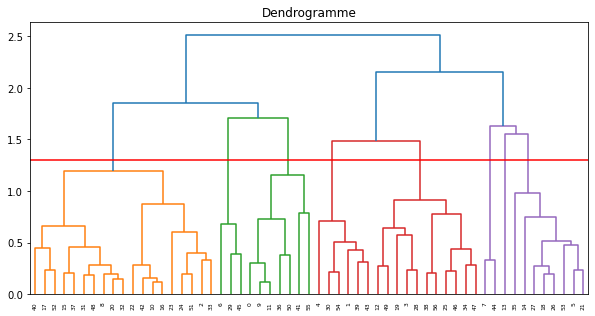

In [162]:
plt.figure(figsize=(10,5))
plt.title("Dendrogramme")
dend = shc.dendrogram(shc.linkage(X_scaled, method="ward"))
plt.axhline(y=1.3, c='red')
plt.show()

On choisit un nombre de 8 clusters.

In [163]:
cluster_cah = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward').fit(X_scaled)

On cherche à connaître les centroïdes de chaque classe. Etant donné que la méthode de classification hiérarchique ne les donne pas directement, nous devons les calculer. Pour cela, on va récupérer la médiane de la distribution de chaque cluster pour chaque variable, ce qui va nous donner 8 centroïdes de 8 coordonnées chacun.

In [164]:
X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_df['cluster_cah'] = pd.DataFrame(cluster_cah.labels_)

In [165]:
centroids_cah = []

for i in range(len(X_scaled_df.drop(columns = {'cluster_cah'}).columns)) :

    tmp = X_scaled_df[[i, 'cluster_cah']].sort_values(by="cluster_cah")
    tmp = pd.get_dummies(tmp, columns=['cluster_cah']).sort_index()
    
    var = []

    for j in range(len(X_scaled_df['cluster_cah'].unique())) :
        tmp['cluster_cah_' + str(j)] = tmp['cluster_cah_' + str(j)].astype(float)
        for k in range(len(tmp)) :
            if tmp['cluster_cah_' + str(j)][k] == 1 :
                tmp.loc[k, 'cluster_cah_' + str(j)] = tmp.loc[k, i]
        tmp = tmp[tmp != 0]
        var.append(tmp['cluster_cah_' + str(j)].median())
    centroids_cah.append(var)
    
centroids_cah = pd.DataFrame(centroids_cah).transpose()

In [166]:
names = np.array(data.drop(columns = {'Zone'}).columns)
for i in range(len(X_scaled_df.drop(columns = {'cluster_cah'}).columns)) :
    centroids_cah.rename(columns = {i : names[i]}, inplace=True)
    
centroids_cah

,PIB/habitant (US$),Population (1000 habitants),Disponibilité alimentaire en quantité de volaille (kg/personne/an),Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille),Proportion importation française (volaille),Proportion de conso viande,Proportion de conso volaille
0,0.074931,0.024777,0.329656,0.169602,0.223549,0.027799,0.339545,0.379011
1,0.002989,0.118348,0.039091,0.303040,0.044101,0.583882,0.100841,0.161494
2,0.649304,0.032488,0.406125,0.282127,0.217529,0.014234,0.432606,0.293013
3,0.190156,0.236075,0.518356,0.364659,0.042275,0.052769,0.481218,0.369148
4,0.023742,0.798039,0.245958,0.301106,0.093594,0.000556,0.394873,0.414352
5,0.416298,0.087142,0.295796,0.985381,0.595516,0.158712,0.380317,0.216034
6,0.418083,0.043752,1.000000,0.028139,1.000000,0.031430,1.000000,0.435816
7,0.070617,0.041493,0.643238,0.254542,0.073382,0.021016,0.525430,0.914380


Maintenant que nous avons identifié tous nos clusters, on peut les représenter sur un radar plot afin de voir la contribution de chaque cluster à chaque variable.

In [167]:
angles=np.linspace(0,2*np.pi,len(names), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

centroids_cah = centroids_cah.append(centroids_cah.loc[0], ignore_index=False)
names = np.append(names, names[0])

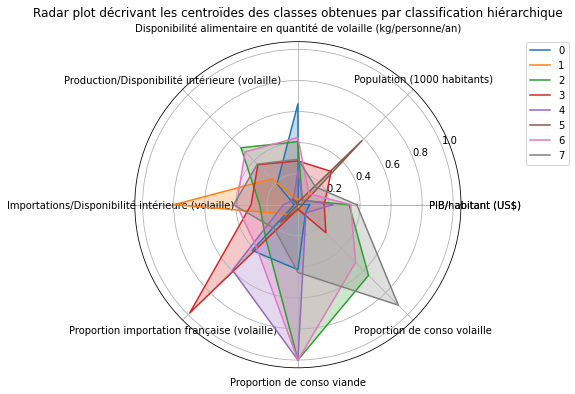

In [168]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)


for i in range(len(names)-1) :
    
    ax.plot(angles,centroids_cah[str(centroids_cah.columns[i])], label = centroids_cah.index[i])
    ax.fill(angles,centroids_cah[str(centroids_cah.columns[i])], alpha = 0.25)

ax.set_thetagrids(angles * 180/np.pi, names)

plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
plt.title("Radar plot décrivant les centroïdes des classes obtenues par classification hiérarchique")
plt.show()

A noter que le nombre de clusters élevé rend la visualisation moins lisible, mais on peut directement voir des groupes assez différents les uns des autres. Par exemple, le cluster n°3 se caractérise par une forte proportion d'importation de volaille française. Les clusters n°2, 4 et 6 se démarquent par une haute consommation de viande. Enfin, le cluster n°1 regroupe les pays qui importent beaucoup de volaille.

Une possibilité pour sélectionner des clusters intéressants serait de choisir ceux qui ont un PIB/habitant assez élevé, qui consomment beaucoup de viande dont beaucoup de volaille et qui ont potentiellement une population assez élevée. Par exemple, les clusters n°2, 6 et 7 pourraient être un bon début.

En revanche, les variables de disponibilité alimentaire de volaille, d'importation française, d'importation et de production sont plus ouvertes à interprétation, quant à si les pays sont plus intéressant sont ceux qui ont les valeurs les plus faibles ou les plus élevées.

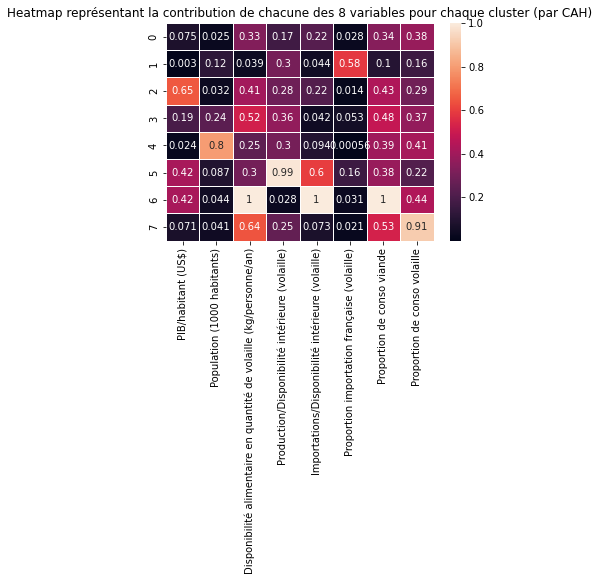

In [169]:
sns.heatmap(centroids_cah.drop_duplicates(), linewidth = 1, annot = True)
plt.title("Heatmap représentant la contribution de chacune des 8 variables pour chaque cluster (par CAH)")
plt.show()

Sur ce visuel-ci, on peut directement voir toutes les contributions. On voit directement que le cluster n°6 regroupe des pays qui consomment beaucoup de viande et qui possèdent beaucoup de volaille importée, mais très peu de la France. On peut aussi faire une lecture en colonne et voir que la plupart des clusters importent peu de volaille de France, à l'exception du cluster n°1.

### Clustering des données : k-means

Maintenant qu'une première segmentation est faite, on essaie par une deuxième méthode afin de pouvoir les mettre en perspective.

On commence par rechercher le nombre de clusters optimal : pour cela on peut utiliser deux méthodes, soit en tentant de maximiser le coefficient de Silhouette pour chaque K, soit en tentant d'optimiser la variance intraclasse totale par la méthode du coude.

In [170]:
silhouettes = []
wcss = []

for i in range(2, 10):
    cluster_k = KMeans(n_clusters = i, n_init = 1, init='k-means++')
    cluster_k.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cluster_k.labels_)
    silhouettes.append(silh)
    wcss.append(cluster_k.inertia_)

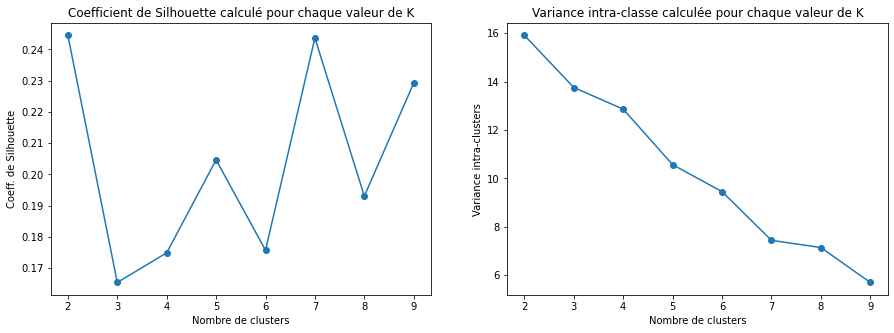

In [171]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121).plot(range(2,10), silhouettes, marker='o')
plt.title("Coefficient de Silhouette calculé pour chaque valeur de K")
plt.xlabel("Nombre de clusters")
plt.ylabel("Coeff. de Silhouette")
fig.add_subplot(122).plot(range(2,10), wcss, marker='o')
plt.title("Variance intra-classe calculée pour chaque valeur de K")
plt.xlabel("Nombre de clusters")
plt.ylabel("Variance intra-clusters")
plt.show()

On choisit ici K = 8.

On procède maintenant à la segmentation :

In [172]:
cluster_k = KMeans(n_clusters = 8).fit(X_scaled)

In [173]:
centroids_k = pd.DataFrame(cluster_k.cluster_centers_)

for i in range(len(centroids_k.columns)) :
    centroids_k = centroids_k.rename(columns = {i : names[i]})
    
centroids_k

,PIB/habitant (US$),Population (1000 habitants),Disponibilité alimentaire en quantité de volaille (kg/personne/an),Production/Disponibilité intérieure (volaille),Importations/Disponibilité intérieure (volaille),Proportion importation française (volaille),Proportion de conso viande,Proportion de conso volaille
0,0.023552,0.086648,0.098916,0.216055,0.177400,0.041309,0.153505,0.314044
1,0.239663,0.579787,0.347754,0.307901,0.073159,0.092568,0.401970,0.347128
2,0.641900,0.025217,0.434445,0.236169,0.198493,0.113335,0.473788,0.298157
3,0.120716,0.137650,0.623906,0.262680,0.076196,0.067773,0.463980,0.794781
4,0.117540,0.061710,0.424185,0.261439,0.193068,0.051235,0.414242,0.416198
5,0.416298,0.087142,0.295796,0.985381,0.595516,0.158712,0.380317,0.216034
6,0.418083,0.043752,1.000000,0.028139,1.000000,0.031430,1.000000,0.435816
7,0.014637,0.077664,0.097267,0.283421,0.058911,0.722588,0.198264,0.277886


In [174]:
centroids_k = centroids_k.append(centroids_k.loc[0], ignore_index=False)

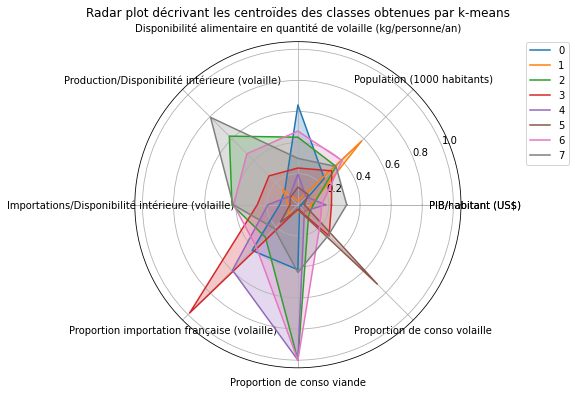

In [175]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)

for i in range(len(names)-1) :
    
    ax.plot(angles,centroids_k[str(centroids_cah.columns[i])], label = centroids_k.index[i])
    ax.fill(angles,centroids_k[str(centroids_cah.columns[i])], alpha = 0.25)

ax.set_thetagrids(angles * 180/np.pi, names)

plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
plt.title("Radar plot décrivant les centroïdes des classes obtenues par k-means")
plt.show()

On peut voir que les clusters sont assez différents entre les deux radar plots. Par exemple, le cluster qui se démarquait par la forte proportion d'importation de volaille française a ici des scores faibles sur les autres variables, ce qui n'était pas le cas plus tôt.

Ici, il semblerait intéressant de sélectionner le cluster n°7 pour les critères énoncés précédemment.

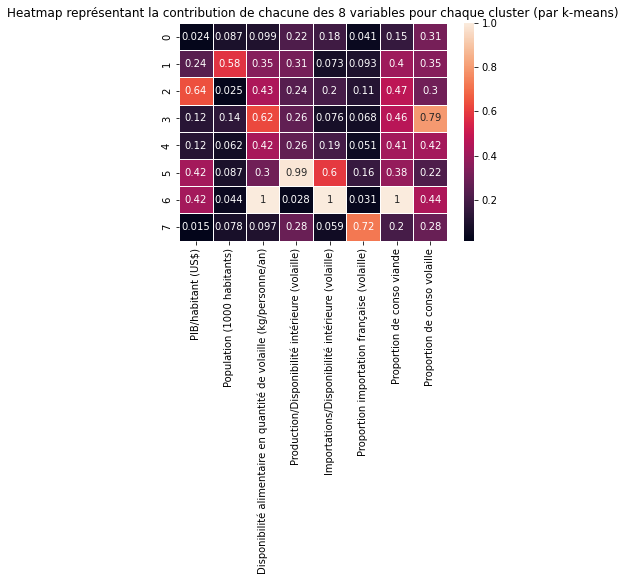

In [176]:
sns.heatmap(centroids_k.drop_duplicates(), linewidth = 1, annot = True)
plt.title("Heatmap représentant la contribution de chacune des 8 variables pour chaque cluster (par k-means)")
plt.show()

Ici, on peut voir que les groupes sont différents : on n'observe plus un cluster qui a 3 scores de 1. Au niveau de l'importation de volaille française, le résultat est un peu plus équilibré entre les différents clusters.

On peut interpréter ces résultats de différentes manières, mais une possibilité serait de choisir des clusters qui ont un score faible en production de volaille, mais un score élevé en importation, ainsi qu'une bonne proportion de consommation de viande, mais surtout de volaille.

Une fois ces groupes choisis, on pourra pousser l'analyse à une échelle plus granulaire en s'intéressant aux pays, à leur ouverture au commerce international et en particulier français, et à leur potentiel d'achat.

Pour pouvoir comparer de façon plus technique les deux méthodes de clustering, nous devons d'abord réaliser une ACP.

### Analyse en Composantes Principales (ACP)

Maintenant, nous allons réduire le nombre de dimensions de notre dataframe, autrement dit, le nombre de variables d'intérêt. Cela permettra de visualiser les clusters. Nous allons pour cela réaliser une ACP.

On commence par normaliser les valeurs de notre dataframe :

In [177]:
X_scaled = preprocessing.StandardScaler().fit_transform(X)
n_components=3

On procède à l'ACP :

In [178]:
pca = decomposition.PCA(n_components).fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [179]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.3029235  0.19063207 0.15824648]
0.6518020419211163


On voit que la première composante explique 30% de la variance totale, la seconde en explique 19%, et la troisième 16%. Au total, cela donne 65% de la variance totale, ce qui est acceptable.

In [180]:
new_components = pd.DataFrame(X_projected).rename(columns = {0 : 'PC1', 1 : 'PC2', 2 : 'PC3'})

In [181]:
new_components['Zone'] = np.array(data['Zone'])
new_components = pd.merge(data, new_components, on="Zone")[['Zone', 'PC1', 'PC2', 'PC3']]

In [182]:
new_components.head(3)

,Zone,PC1,PC2,PC3
0,Afghanistan,-2.391792,0.126869,-0.501313
1,Afrique du Sud,1.152403,-1.814173,1.392088
2,Albanie,-0.757669,-0.634682,-1.238930


### Liens entre les variables

Nous devons comprendre la réduction en composantes principales en terme des variables initiales :

Pour cela, on choisit de visualiser le cercle des corrélations pour chaque combinaison des composantes principales. En effet, on en a choisi trois, or le cercle est en deux dimensions, donc on réalise trois cercles pour voir toutes les décompositions.

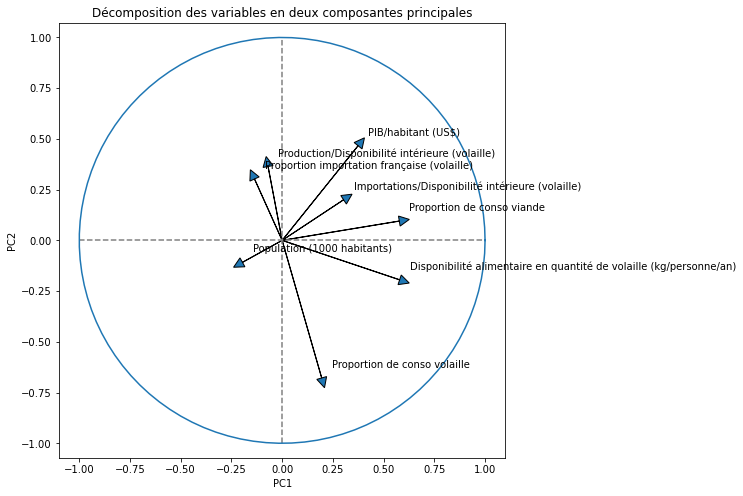

In [183]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0, 0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             data.drop(columns = {'Zone'}).columns.values[i])
    
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.title("Décomposition des variables en deux composantes principales")
plt.show()

Dans un premier temps, on voit que la PC1 est négativement corrélée avec la proportion de consommation de volaille. On voit aussi que la PC2 est est assez corrélée avec la proportion de consommation de viande et la disponibilité alimentaire de volaille.

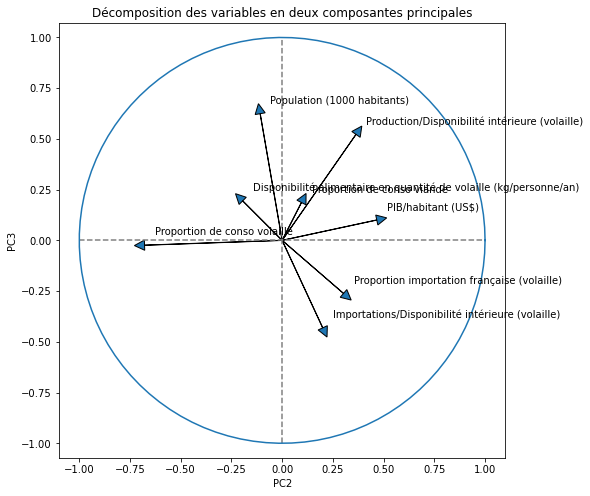

In [184]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0, 0,
             pca.components_[1, i],
             pca.components_[2, i],
             head_width=0.05,
             head_length=0.05)

    plt.text(pca.components_[1, i] + 0.05,
             pca.components_[2, i] + 0.05,
             data.drop(columns = {'Zone'}).columns.values[i])
    
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')

plt.xlabel("PC2")
plt.ylabel("PC3")

plt.title("Décomposition des variables en deux composantes principales")
plt.show()

On voit ici aussi une anti-corrélation entre la PC3 et la proportion de consommation de volaille, ainsi qu'une corrélation avec le PIB/habitant. En revanche, dans ce plan-là, on voit une corrélation entre la PC2 et la population, ainsi qu'une anti-corrélation avec le ratio importations/disponibilité et une corrélation avec le ratio productions/disponibilité.

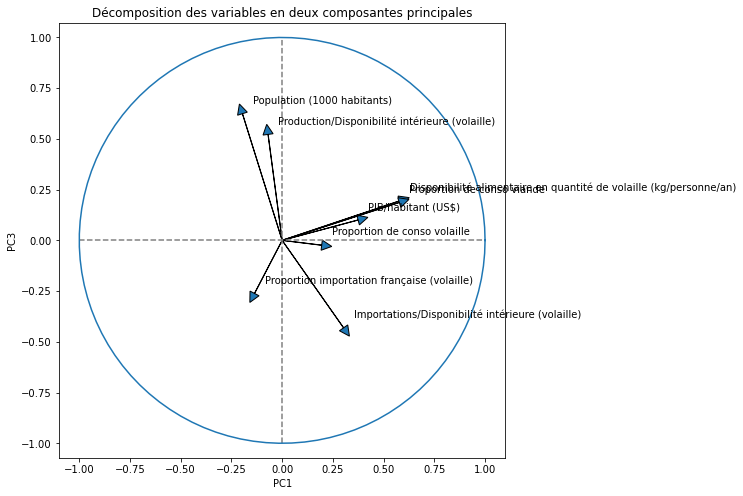

In [185]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0, 0,  
             pca.components_[0, i],  
             pca.components_[2, i],  
             head_width=0.05,
             head_length=0.05)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[2, i] + 0.05,
             data.drop(columns = {'Zone'}).columns.values[i])
    
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')

plt.xlabel("PC1")
plt.ylabel("PC3")

plt.title("Décomposition des variables en deux composantes principales")
plt.show()

Ici, on voit une corrélation entre la PC1 et la population et la production de volaille, ainsi qu'une anti-corrélation avec l'importation de volaille. De plus, on voit une corrélation entre la PC3 et la consommation de viande ainsi que la disponibilité de volaille.

Il est intéressant de voir que les différentes projections apportent différentes informations. Ainsi :

La PC1 est liée à des pays peuplés, qui produisent beaucoup et importent peu de volaille, et qui consomment peu de volaille.

La PC2 est liée à des pays peuplés qui consomment beaucoup de viande et qui disposent de beaucoup de volaille, celle-ci étant plus produite localement qu'importée.

La PC3 est liée à des pays riches, qui consomment beaucoup de viande et qui disposent de beaucoup de volaille, mais qui en consomment peu.

### Comparaison des deux méthodes

Nous allons maintenant mettre les deux méthodes de clustering en perspective :

In [186]:
fig = px.scatter_3d(new_components, x='PC1', y='PC2', z='PC3', color=cluster_cah.labels_)
fig.show()

In [187]:
fig = px.scatter_3d(new_components, x='PC1', y='PC2', z='PC3', color=cluster_k.labels_)
fig.show()

En observant bien les deux graphiques, on remarque un certain nombre de différences dans les clusters.

Pour faire un choix entre les deux, il faut garder à l'esprit que la méthode de classification hiérarchique a une grande complexité algorithmique : comme elle calcule les distances entre tous les points deux à deux avant de les classer par distance croissante (ou décroissante en classification hiérarchique descendante ou divisive) elle est lourde et demande de la mémoire. De plus, en rechercher les centroïdes demande un travail supplémentaire. Ainsi, cet algorithme ne convient que pour des jeux de données assez légers. De plus, le choix du nombre de clusters, qui doit être fait manuellement sur le dendrogramme, peut être arbitraire ou discutable.

L'algorithme de k-means, en revanche, est plus autonome, plus rapide et plus polyvalent. Son principal inconvénient est qu'il faut lui indiquer en amont le nombre de clusters souhaité. Pour cela, on a vu que l'on avait plusieurs méthodes mathématiques, qui donnent automatiquement le nombre de clusters optimal, mais c'est un travail qu'il faut pré-faire pour l'algorithme.